### !!! Use sim312 kernel (tskit 0.6.0 <) !!!

## Import Dependencies

In [2]:
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import ruptures as rpt
# from scipy.stats import norm
from PSlim import Experiment, get_eps, ROC, ROCAUC

In [3]:
Train = True # False if you do analysis with given simulations and estimates
pyslurm = None  # instead of '/home/enes/pyslurm/'
srun = None
srun_est = None

In [3]:
# if pyslurm:
#     sys.path.append(pyslurm)
#     from pyslurm import Slurm

#     slurm = Slurm(account='stats_dept1')

#     srun = slurm.batch('source activate slim', 
#                        '#time=0-1:00:00',
#                        '#mem=1000M',
#                        '#mem-per-cpu=None', 
#                        '#job-name="sim"')   

#     srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
#                            '#mem-per-cpu=300',
#                            '#job-name="est"',
#                            '#cpus-per-task=3')

## Set Parameters

In [4]:
N = 50
Ne = 10000
L = 100000
r = 1.25e-8
mu = 2.5e-8

extmut = 0 # no extra mutation (just one)
Until = 100000 # make sure model runs until it reaches the desired frequency Until>>Ne
h = 0.5

Args = {}

Args['Fn'] = {'Simulator':'slim', 'slimTxt':'Slim.txt', 
              'N':N, 'Ne':Ne, 'L':L, 'r':r, 'mu':mu, 
              's':0, 'h':0.5, 'extmut':0, 'reset_lost': 0,
              'Until':Ne, 'Freq':0.25, 'rep':0, 
              'srun':srun, 'srun_est':srun_est,
              'etapath':'etas/Fn.json', 'start': Until + 100,
              'name':'Neutral Model'}

# for s in [0.02, 0.01, 0.003, 0.001]:
#     for Freq in [0.25, 0.5, 0.75]:
# # for s in [0.01]:
# #     for Freq in [0.75]:
#         name = 's='+str(s)+'F='+str(Freq)
#         arg = Args['Fn'].copy()
#         arg['s'] = s
#         arg['Freq'] = Freq
#         arg['Until'] = 300000
#         arg['name'] = name
#         arg['reset_lost'] = 1
#         Args[name] = arg

In [5]:
cID = 3 # simulation class id for directional selection constant pop size simulations
nrep = 500 # For initial testing
X = Experiment(cID, nrep, Args)

## Simulate Trees (Skip and Use Cached Results unless first time)

In [6]:
if Train:
    X.sim()

running setid: Fn
pslim set up for Fn
commands set up
running cmd1
running cmd with _run: ['slim', '-s', '3000000', '-d', 'simID=3000000', 'slimfiles/Slim_Neutral_Model.slim']
// Initial random seed:
3000000

// RunInitializeCallbacks():
initializeTreeSeq();
initializeMutationRate(0);
initializeMutationType(1, 0.5, "f", 0);
initializeMutationType(3, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 100000);
initializeRecombinationRate(1.25e-08);

// Starting run at tick <start>:
1 

progress: tick=1000
progress: tick=2000
progress: tick=3000
progress: tick=4000
progress: tick=5000
progress: tick=6000
progress: tick=7000
progress: tick=8000
progress: tick=9000
progress: tick=10000
0.0
cmd with _run done in 33.2s (returncode=0)
running cmd2
running cmd with _run: ['python', 'recap.py', '3000000', '50', '10000', '1.25e-08', '2.5e-08']
recap is starting
/opt/anaconda3/envs/sim312/lib/python3.12/site-packages/msprime/ancestry.py:1290: TimeUnitsMismatchWar

In [6]:
X.calc_sfs()

In [ ]:
# Rebuild `X` from on-disk trees (no simulations)
import os, re, json
import numpy as np
import tskit

from PSlim import Experiment  # import from your PSlim.py

# --- your existing Args and cID ---
cID = 3
X = Experiment(cID=cID, nrep=100, Args=Args)   # nrep is a placeholder; we'll overwrite simIDs

TREES_DIR = "trees"  # <- exactly the folder you asked for (relative path: ./trees)

def _matching_paths(regex, folder=TREES_DIR):
    """Return paths like trees/r########.trees that match the regex."""
    r = re.compile(regex)
    files = os.listdir(folder) if os.path.isdir(folder) else []
    return [os.path.join(folder, f) for f in files if r.match(f)]

def _extract_sim_ids(paths):
    """From paths like trees/r3020001.trees or trees/ir3020001.trees, return integer IDs."""
    out = []
    for p in paths:
        m = re.search(r'(\d+)\.trees$', p)
        if m:
            out.append(int(m.group(1)))
    return sorted(set(out))

# Fill in X.simIDs by discovering what’s already on disk (pattern: r{cID}{set_index:02d}{rep:04d}.trees)
for i, setid in enumerate(X.setids):
    regex = f"r{cID}{i:02d}[0-9]{{4}}\\.trees"   # e.g. r300000.trees pattern (escaped dot)
    rpaths = _matching_paths(regex, folder=TREES_DIR)  # returns trees/<filename>
    found_ids = _extract_sim_ids(rpaths)               # just the numeric IDs
    X.simIDs[setid] = found_ids
    if not found_ids:
        print(f"[warn] no r*.trees found for setid={setid} (pattern: {regex})")

# Recompute SFS from the trees we found (fast)
X.calc_sfs()

print("Rebuilt X:")
for sid in X.setids:
    print(f"  {sid}: {len(X.simIDs[sid])} replicates; AFS length={len(X.AFS[sid])}")


Rebuilt X:
  Fn: 11 replicates; AFS length=49
  s=0.02F=0.25: 10 replicates; AFS length=49
  s=0.02F=0.5: 10 replicates; AFS length=49
  s=0.02F=0.75: 10 replicates; AFS length=49
  s=0.01F=0.25: 10 replicates; AFS length=49
  s=0.01F=0.5: 10 replicates; AFS length=49
  s=0.01F=0.75: 10 replicates; AFS length=49
  s=0.003F=0.25: 10 replicates; AFS length=49
  s=0.003F=0.5: 10 replicates; AFS length=49
  s=0.003F=0.75: 10 replicates; AFS length=49
  s=0.001F=0.25: 10 replicates; AFS length=49
  s=0.001F=0.5: 10 replicates; AFS length=49
  s=0.001F=0.75: 10 replicates; AFS length=49


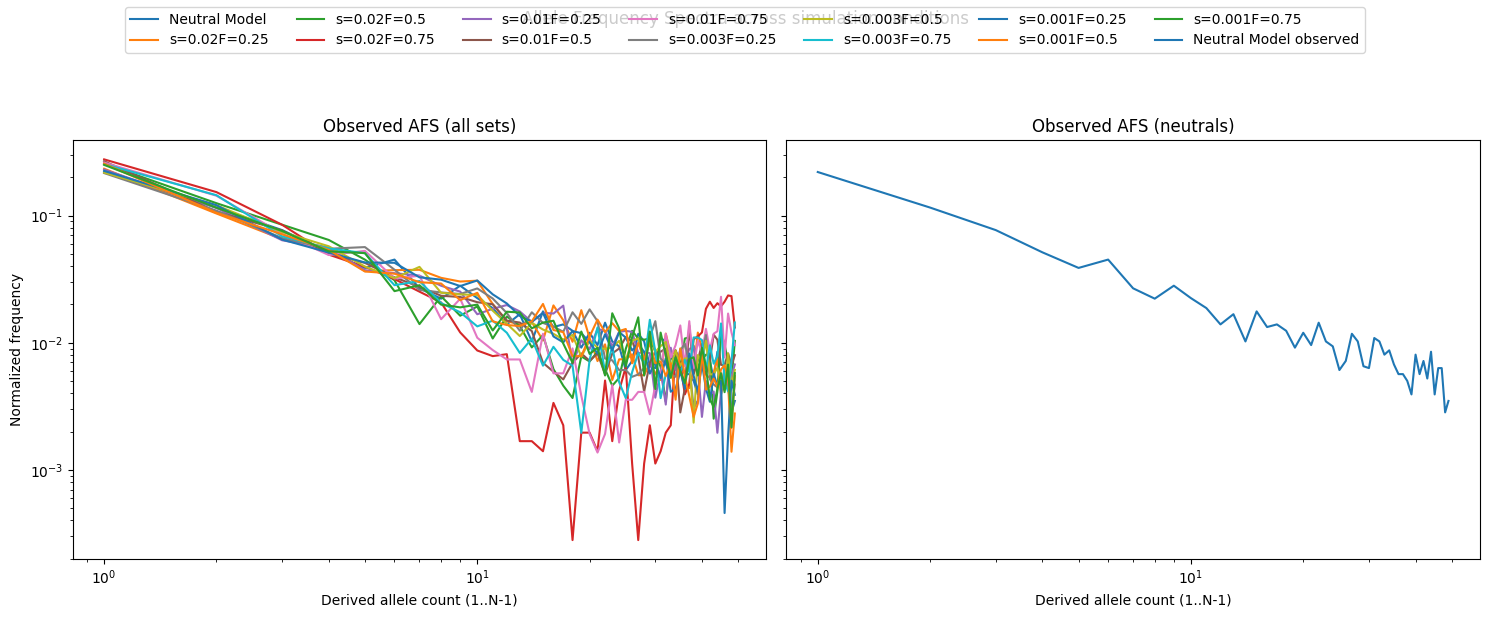

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

# Left panel: all sets' observed AFS
for setid in X.setids:
    name = Args[setid]['name']
    sfs = X.AFS[setid]
    if sfs.sum() == 0:
        continue  # nothing accumulated yet
    x = range(1, len(sfs) + 1)
    ax[0].plot(x, sfs / sfs.sum(), label=name)

# Right panel: neutrals; if ebl exists we'll overlay it (but this is Option A)
has_ebl = hasattr(X, "ebl")
for setid in X.neutrals:
    name = Args[setid]['name']
    sfs = X.AFS[setid]
    if sfs.sum() == 0:
        continue
    x = range(1, len(sfs) + 1)
    if has_ebl:  # won't run unless you've called X.train_eta()
        ebl = X.ebl[setid]
        ax[1].plot(x, ebl / ebl.sum(), color="black", lw=2, label="expected (ebl)" if "expected (ebl)" not in ax[1].get_legend_handles_labels()[1] else None)
    ax[1].plot(x, sfs / sfs.sum(), label=f"{name} observed")

# Log scales on the right panel (like the original)
ax[1].set_xscale('log')
ax[1].set_yscale('log')

# Titles and axis labels
ax[0].set_title("Observed AFS (all sets)")
ax[1].set_title("Observed AFS (neutrals)")
ax[0].set_xlabel("Derived allele count (1..N-1)")
ax[1].set_xlabel("Derived allele count (1..N-1)")
ax[0].set_ylabel("Normalized frequency")

# Figure-level legend and title
fig.legend(ncol=7, loc='upper center')
fig.suptitle("Allele Frequency Spectra across simulation conditions", y=1.02)

plt.tight_layout(rect=[0, 0, 1, 0.92])